<a href="https://colab.research.google.com/github/jyosa/sd_mccolombia/blob/main/sd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  **Stable Diffusion v2.1** 

Stable Diffusion es un modelo de de aprendizaje profundo texto a imagen  lanzado en 2022. Se utiliza principalmente para generar imágenes detalladas condicionadas a descripciones de texto, aunque también se puede aplicar a otras tareas como pintar, pintar y generar imágenes a imágenes. 

Stable Diffusion es un modelo de difusión latente, una variedad de red neuronal generativa profunda desarrollada por el grupo CompVis en LMU Munich. El modelo ha sido lanzado por una colaboración de Stability AI, CompVis LMU y Runway con el apoyo de EleutherAI y LAION. 

El código y el  modelo de Stable Diffusion se han publicado  y puede ejecutarse en la mayoría de los equipos de consumo equipados con una GPU  con al menos 8 GB de RAM. Esto marcó una desviación de los modelos de texto a imagen patentados anteriores, como DALL-E y Midjourney, a los que solo se podía acceder a través de servicios en la nube.

El Stable Diffusion V1 original dirigido por CompVis cambió la naturaleza de los modelos de IA de código abierto y generó cientos de otros modelos e innovaciones en todo el mundo. Tuvo uno de los ascensos más rápidos a 10 000 estrellas Github de cualquier software, alcanzando las 33 000 estrellas en menos de dos meses.

La versión Stable Diffusion 2.0 incluye modelos robustos de texto a imagen entrenados con un codificador de texto completamente nuevo (OpenCLIP), desarrollado por LAION con el apoyo de Stability AI, que mejora en gran medida la calidad de las imágenes generadas en comparación con las versiones anteriores de V1. Los modelos de texto a imagen de esta versión pueden generar imágenes con resoluciones predeterminadas de 512x512 píxeles y 768x768 píxeles.

Estos modelos se entrenan en un subconjunto estético del conjunto de datos LAION-5B creado por el equipo de DeepFloyd en Stability AI, que luego se filtra aún más para eliminar el contenido para adultos utilizando el filtro NSFW de LAION. [1]

Este es un ejemplo del siguiente promt:

Cute girl, pretty! , young!!, latin, face of shakira , in a chemistry laboratory
, 4k, Unreal Engine 5, fine details, intricate

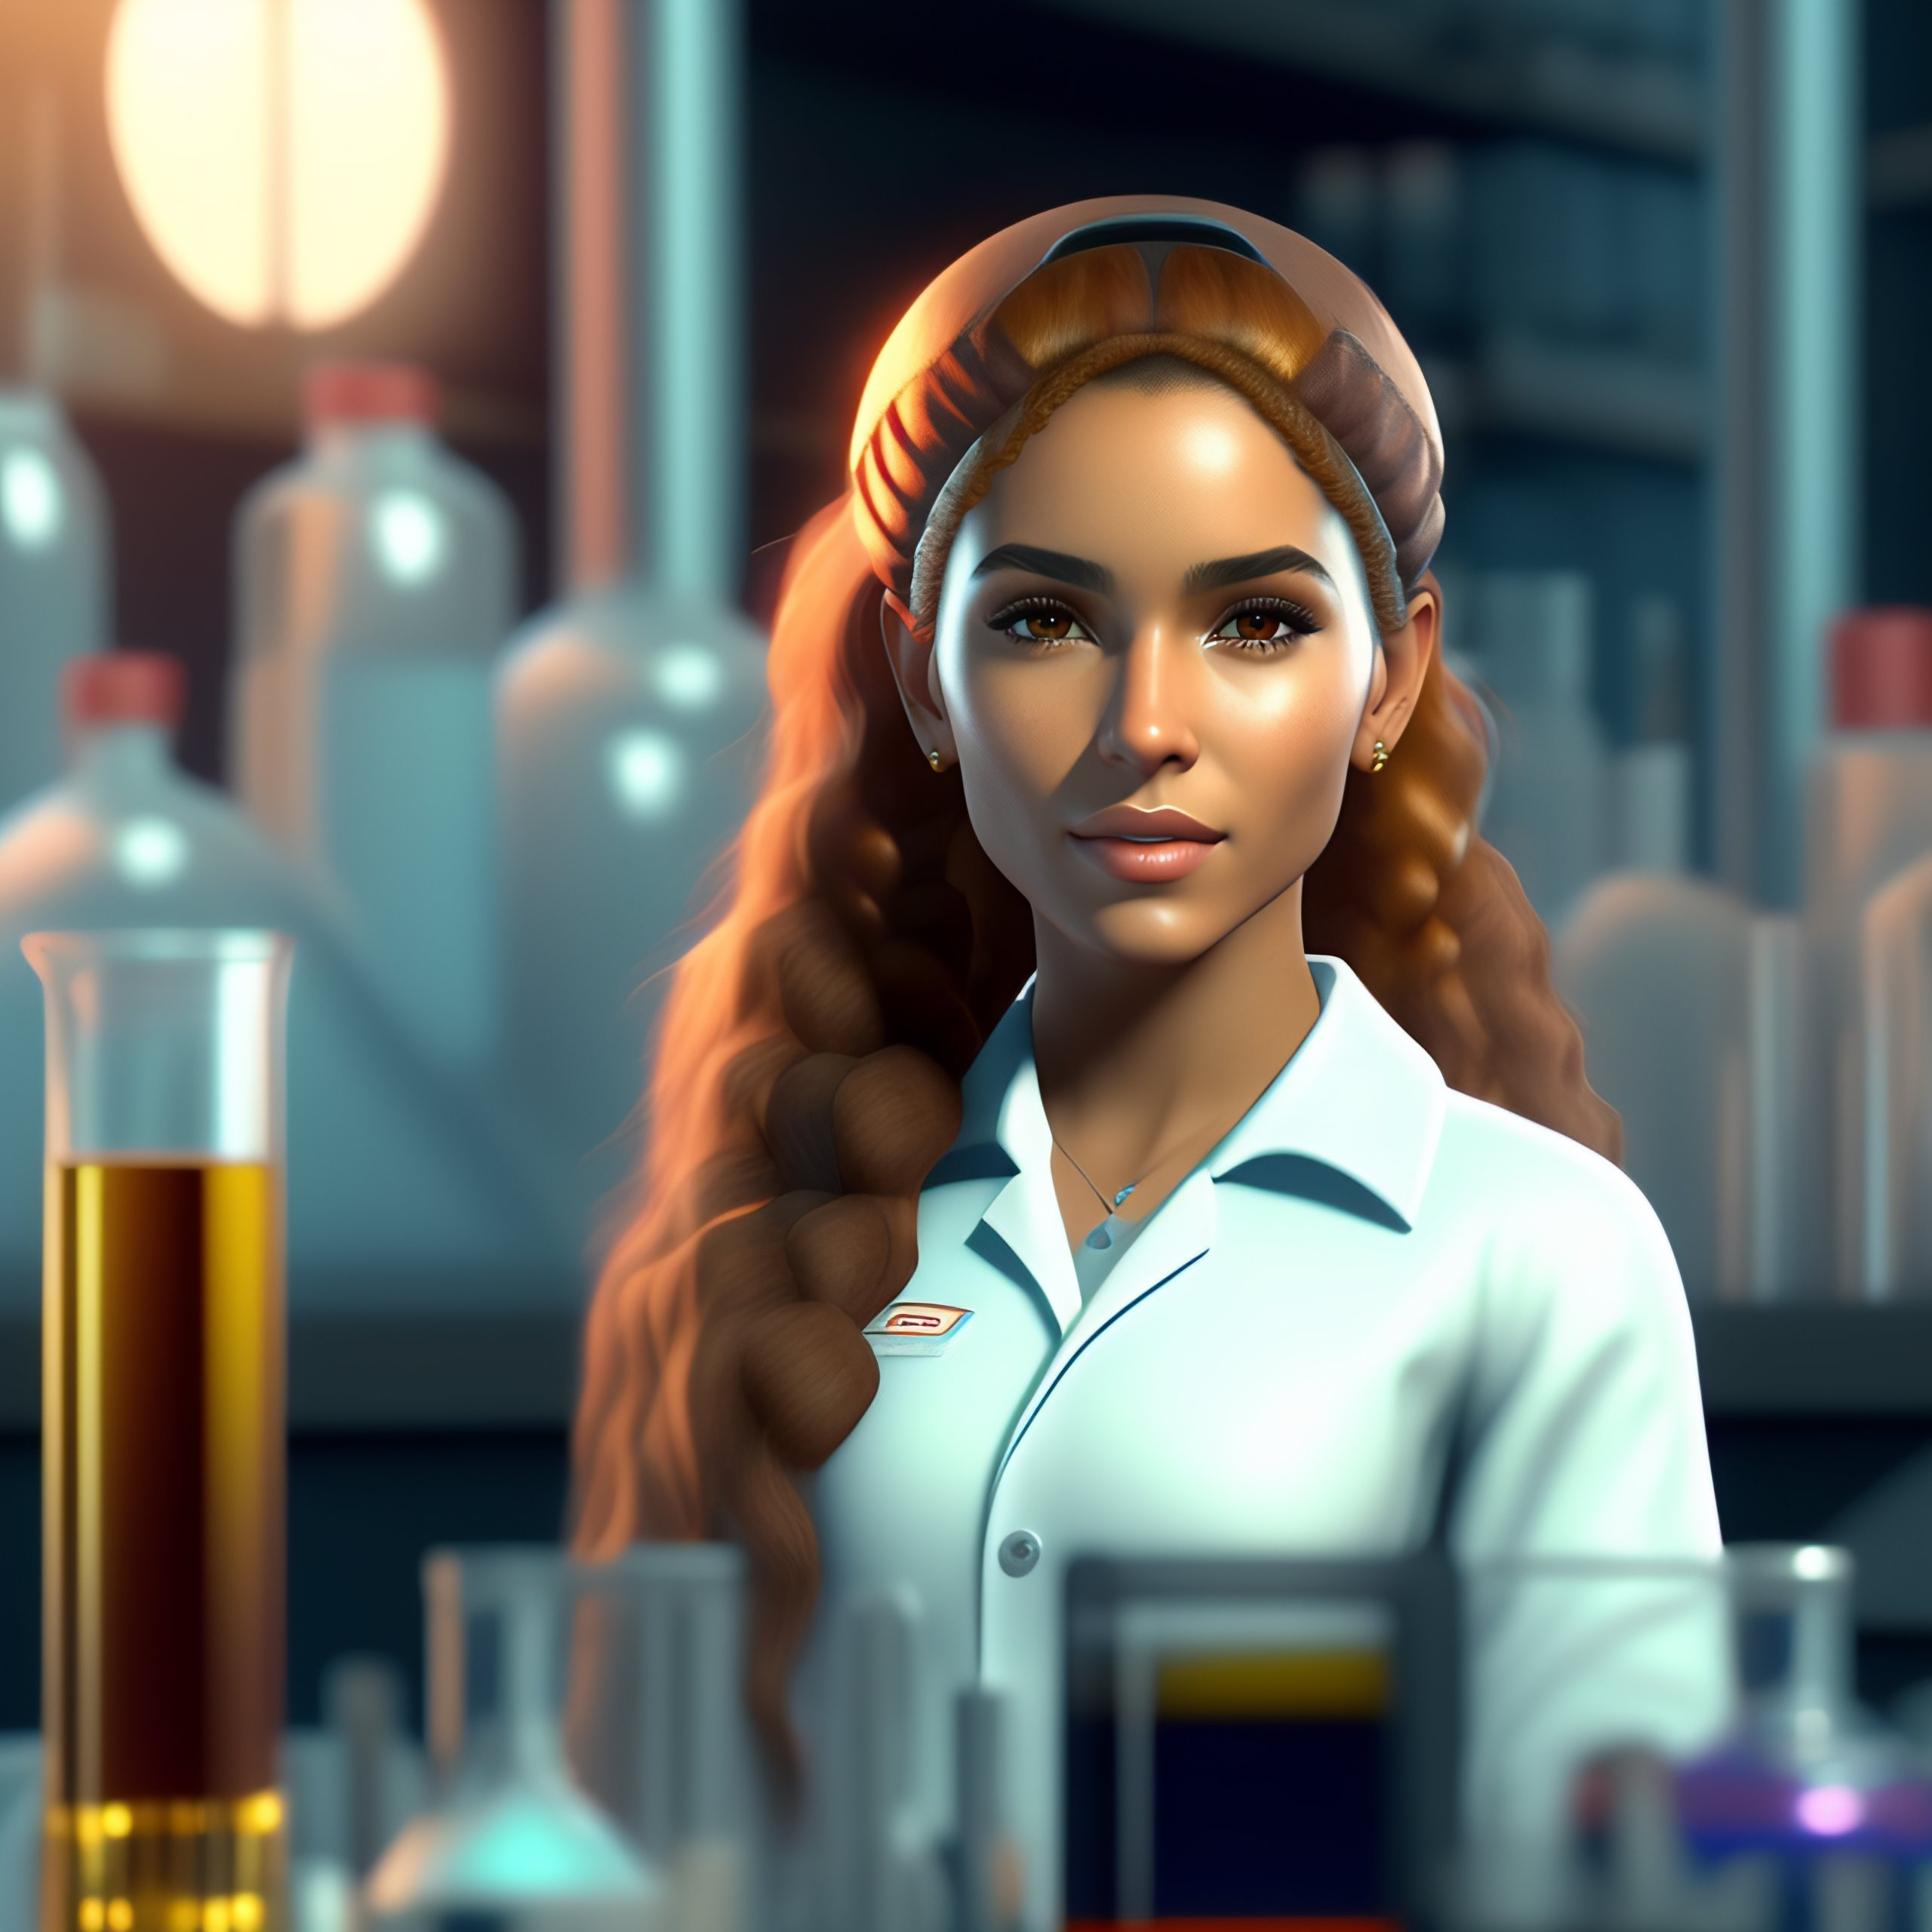



En stable diffusion 2 se usa una nueva funcionalidad llamada Negative prompt, en el negative promt podemos insertar texto que no queremos que aparezca en la imagen, por ejemplo si la imagen es d eun cachorro en la luna y noi quiero que aparezca el planeta tierra de fondo, agrego dicha descripción en el texto.

[1] https://stability.ai/blog/stable-diffusion-v2-release



In [ ]:
#@title instalar dependencias y correr el GUI!

!pip install --upgrade git+https://github.com/huggingface/diffusers.git@main
!pip install transformers
!pip install accelerate
!pip install scipy
!pip install triton
!pip install ftfy
!pip install gradio -q

from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionUpscalePipeline, DiffusionPipeline, DPMSolverMultistepScheduler
import gradio as gr
import torch
from PIL import Image
import random

state = None
current_steps = 25

# model_id = 'stabilityai/stable-diffusion-2'
model_id = 'stabilityai/stable-diffusion-2-1'

scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      revision="fp16" if torch.cuda.is_available() else "fp32",
      torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
      scheduler=scheduler
    ).to("cuda")
pipe.enable_attention_slicing()
# pipe.enable_xformers_memory_efficient_attention()

pipe_i2i = None
pipe_upscale = None
pipe_inpaint = None

attn_slicing_enabled = True
mem_eff_attn_enabled = False

modes = {
    'txt2img': 'Text to Image',
    'img2img': 'Image to Image',
    'inpaint': 'Inpainting',
    'upscale4x': 'Upscale 4x',
}
current_mode = modes['txt2img']

def error_str(error, title="Error"):
    return f"""#### {title}
            {error}"""  if error else ""

def update_state(new_state):
  global state
  state = new_state

def update_state_info(old_state):
  if state and state != old_state:
    return gr.update(value=state)

def set_mem_optimizations(pipe):
    if attn_slicing_enabled:
      pipe.enable_attention_slicing()
    else:
      pipe.disable_attention_slicing()
    
    # if mem_eff_attn_enabled:
    #   pipe.enable_xformers_memory_efficient_attention()
    # else:
    #   pipe.disable_xformers_memory_efficient_attention()

def get_i2i_pipe(scheduler):
    
    update_state("Loading image to image model...")

    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
      model_id,
      revision="fp16" if torch.cuda.is_available() else "fp32",
      torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
      scheduler=scheduler
    )
    set_mem_optimizations(pipe)
    pipe.to("cuda")
    return pipe

def get_inpaint_pipe():
  
  update_state("Loading inpainting model...")

  pipe = DiffusionPipeline.from_pretrained(
      "stabilityai/stable-diffusion-2-inpainting",
      revision="fp16" if torch.cuda.is_available() else "fp32",
      torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
      # scheduler=scheduler # TODO currently setting scheduler here messes up the end result. A bug in Diffusers🧨
    ).to("cuda")
  pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
  pipe.enable_attention_slicing()
  # pipe.enable_xformers_memory_efficient_attention()
  return pipe

def get_upscale_pipe(scheduler):
    
    update_state("Loading upscale model...")

    pipe = StableDiffusionUpscalePipeline.from_pretrained(
      "stabilityai/stable-diffusion-x4-upscaler",
      revision="fp16" if torch.cuda.is_available() else "fp32",
      torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
      # scheduler=scheduler
    )
    # pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    set_mem_optimizations(pipe)
    pipe.to("cuda")
    return pipe

def switch_attention_slicing(attn_slicing):
    global attn_slicing_enabled
    attn_slicing_enabled = attn_slicing

def switch_mem_eff_attn(mem_eff_attn):
    global mem_eff_attn_enabled
    mem_eff_attn_enabled = mem_eff_attn

def pipe_callback(step: int, timestep: int, latents: torch.FloatTensor):
    update_state(f"{step}/{current_steps} steps")#\nTime left, sec: {timestep/100:.0f}")

def inference(inf_mode, prompt, n_images, guidance, steps, width=768, height=768, seed=0, img=None, strength=0.5, neg_prompt=""):

  update_state(" ")

  global current_mode
  if inf_mode != current_mode:
    pipe.to("cuda" if inf_mode == modes['txt2img'] else "cpu")

    if pipe_i2i is not None:
      pipe_i2i.to("cuda" if inf_mode == modes['img2img'] else "cpu")

    if pipe_inpaint is not None:
      pipe_inpaint.to("cuda" if inf_mode == modes['inpaint'] else "cpu")

    if pipe_upscale is not None:
      pipe_upscale.to("cuda" if inf_mode == modes['upscale4x'] else "cpu")

    current_mode = inf_mode
    
  if seed == 0:
    seed = random.randint(0, 2147483647)

  generator = torch.Generator('cuda').manual_seed(seed)
  prompt = prompt

  try:
    
    if inf_mode == modes['txt2img']:
      return txt_to_img(prompt, n_images, neg_prompt, guidance, steps, width, height, generator, seed), gr.update(visible=False, value=None)
    
    elif inf_mode == modes['img2img']:
      if img is None:
        return None, gr.update(visible=True, value=error_str("Image is required for Image to Image mode"))

      return img_to_img(prompt, n_images, neg_prompt, img, strength, guidance, steps, width, height, generator, seed), gr.update(visible=False, value=None)
    
    elif inf_mode == modes['inpaint']:
      if img is None:
        return None, gr.update(visible=True, value=error_str("Image is required for Inpainting mode"))

      return inpaint(prompt, n_images, neg_prompt, img, guidance, steps, width, height, generator, seed), gr.update(visible=False, value=None)

    elif inf_mode == modes['upscale4x']:
      if img is None:
        return None, gr.update(visible=True, value=error_str("Image is required for Upscale mode"))

      return upscale(prompt, n_images, neg_prompt, img, guidance, steps, generator, seed), gr.update(visible=False, value=None)
  except Exception as e:
    return None, gr.update(visible=True, value=error_str(e))

def txt_to_img(prompt, n_images, neg_prompt, guidance, steps, width, height, generator, seed):

    result = pipe(
      prompt,
      num_images_per_prompt = n_images,
      negative_prompt = neg_prompt,
      num_inference_steps = int(steps),
      guidance_scale = guidance,
      width = width,
      height = height,
      generator = generator,
      callback=pipe_callback).images

    update_state(f"Done. Seed: {seed}")

    return result

def img_to_img(prompt, n_images, neg_prompt, img, strength, guidance, steps, width, height, generator, seed):

    global pipe_i2i
    if pipe_i2i is None:
      pipe_i2i = get_i2i_pipe(scheduler)

    img = img['image']
    ratio = min(height / img.height, width / img.width)
    img = img.resize((int(img.width * ratio), int(img.height * ratio)), Image.LANCZOS)
    result = pipe_i2i(
      prompt,
      num_images_per_prompt = n_images,
      negative_prompt = neg_prompt,
      init_image = img,
      num_inference_steps = int(steps),
      strength = strength,
      guidance_scale = guidance,
      width = width,
      height = height,
      generator = generator,
      callback=pipe_callback).images

    update_state(f"Done. Seed: {seed}")
        
    return result

# TODO Currently supports only 512x512 images
def inpaint(prompt, n_images, neg_prompt, img, guidance, steps, width, height, generator, seed):

    global pipe_inpaint
    if pipe_inpaint is None:
      pipe_inpaint = get_inpaint_pipe()

    inp_img = img['image']
    mask = img['mask']
    inp_img = square_padding(inp_img)
    mask = square_padding(mask)

    # # ratio = min(height / inp_img.height, width / inp_img.width)
    # ratio = min(512 / inp_img.height, 512 / inp_img.width)
    # inp_img = inp_img.resize((int(inp_img.width * ratio), int(inp_img.height * ratio)), Image.LANCZOS)
    # mask = mask.resize((int(mask.width * ratio), int(mask.height * ratio)), Image.LANCZOS)

    inp_img = inp_img.resize((512, 512))
    mask = mask.resize((512, 512))

    result = pipe_inpaint(
      prompt,
      image = inp_img,
      mask_image = mask,
      num_images_per_prompt = n_images,
      negative_prompt = neg_prompt,
      num_inference_steps = int(steps),
      guidance_scale = guidance,
      # width = width,
      # height = height,
      generator = generator,
      callback=pipe_callback).images
        
    update_state(f"Done. Seed: {seed}")

    return result

def square_padding(img):
    width, height = img.size
    if width == height:
        return img
    new_size = max(width, height)
    new_img = Image.new('RGB', (new_size, new_size), (0, 0, 0, 255))
    new_img.paste(img, ((new_size - width) // 2, (new_size - height) // 2))
    return new_img

def upscale(prompt, n_images, neg_prompt, img, guidance, steps, generator):

    global pipe_upscale
    if pipe_upscale is None:
      pipe_upscale = get_upscale_pipe(scheduler)

    img = img['image']
    return upscale_tiling(prompt, neg_prompt, img, guidance, steps, generator)

    # result = pipe_upscale(
    #     prompt,
    #     image = img,
    #     num_inference_steps = int(steps),
    #     guidance_scale = guidance,
    #     negative_prompt = neg_prompt,
    #     num_images_per_prompt = n_images,
    #     generator = generator).images[0]

    # return result

def upscale_tiling(prompt, neg_prompt, img, guidance, steps, generator):

    width, height = img.size

    # calculate the padding needed to make the image dimensions a multiple of 128
    padding_x = 128 - (width % 128) if width % 128 != 0 else 0
    padding_y = 128 - (height % 128) if height % 128 != 0 else 0

    # create a white image of the right size to be used as padding
    padding_img = Image.new('RGB', (padding_x, padding_y), color=(255, 255, 255, 0))

    # paste the padding image onto the original image to add the padding
    img.paste(padding_img, (width, height))

    # update the image dimensions to include the padding
    width += padding_x
    height += padding_y

    if width > 128 or height > 128:

        num_tiles_x = int(width / 128)
        num_tiles_y = int(height / 128)

        upscaled_img = Image.new('RGB', (img.size[0] * 4, img.size[1] * 4))
        for x in range(num_tiles_x):
            for y in range(num_tiles_y):
                update_state(f"Upscaling tile {x * num_tiles_y + y + 1}/{num_tiles_x * num_tiles_y}")
                tile = img.crop((x * 128, y * 128, (x + 1) * 128, (y + 1) * 128))

                upscaled_tile = pipe_upscale(
                    prompt="",
                    image=tile,
                    num_inference_steps=steps,
                    guidance_scale=guidance,
                    # negative_prompt = neg_prompt,
                    generator=generator,
                ).images[0]

                upscaled_img.paste(upscaled_tile, (x * upscaled_tile.size[0], y * upscaled_tile.size[1]))

        return [upscaled_img]
    else:
        return pipe_upscale(
            prompt=prompt,
            image=img,
            num_inference_steps=steps,
            guidance_scale=guidance,
            negative_prompt = neg_prompt,
            generator=generator,
        ).images



def on_mode_change(mode):
  return gr.update(visible = mode in (modes['img2img'], modes['inpaint'], modes['upscale4x'])), \
         gr.update(visible = mode == modes['inpaint']), \
         gr.update(visible = mode == modes['upscale4x']), \
         gr.update(visible = mode == modes['img2img'])

def on_steps_change(steps):
  global current_steps
  current_steps = steps

css = """.main-div div{display:inline-flex;align-items:center;gap:.8rem;font-size:1.75rem}.main-div div h1{font-weight:900;margin-bottom:7px}.main-div p{margin-bottom:10px;font-size:94%}a{text-decoration:underline}.tabs{margin-top:0;margin-bottom:0}#gallery{min-height:20rem}
"""
with gr.Blocks(css=css) as demo:
    gr.HTML(
        f"""
          <div class="main-div">
            <div>
              <h1>Stable Diffusion 2.1</h1>
            </div><br>
            <p> Model used: <a href="https://huggingface.co/stabilityai/stable-diffusion-2-1/blob/main/v2-1_768-ema-pruned.ckpt" target="_blank">v2-1_768-ema-pruned.ckpt</a></p>
            Running on <b>{"GPU 🔥" if torch.cuda.is_available() else "CPU 🥶"}</b>
          </div>
        """
    )
    with gr.Row():
        
        with gr.Column(scale=55):
          with gr.Group():
              with gr.Row():
                prompt = gr.Textbox(label="Prompt", show_label=False, max_lines=2,placeholder=f"Enter prompt").style(container=False)
                generate = gr.Button(value="Generate").style(rounded=(False, True, True, False))

              gallery = gr.Gallery(label="Generated images", show_label=False).style(grid=[2], height="auto")
          state_info = gr.Textbox(label="State", show_label=False, max_lines=2).style(container=False)
          error_output = gr.Markdown(visible=False)

        with gr.Column(scale=45):
          inf_mode = gr.Radio(label="Inference Mode", choices=list(modes.values())[:4], value=modes['txt2img']) # TODO remove [:3] limit
          
          with gr.Group(visible=False) as i2i_options:
            image = gr.Image(label="Image", height=128, type="pil", tool='sketch')
            inpaint_info = gr.Markdown("Inpainting resizes and pads images to 512x512", visible=False)
            upscale_info = gr.Markdown("""Best for small images (128x128 or smaller).<br>
                                        Bigger images will be sliced into 128x128 tiles which will be upscaled individually.<br>
                                        This is done to avoid running out of GPU memory.""", visible=False)
            strength = gr.Slider(label="Transformation strength", minimum=0, maximum=1, step=0.01, value=0.5)

          with gr.Group():
            neg_prompt = gr.Textbox(label="Negative prompt", placeholder="What to exclude from the image")

            n_images = gr.Slider(label="Number of images", value=1, minimum=1, maximum=4, step=1)
            with gr.Row():
              guidance = gr.Slider(label="Guidance scale", value=7.5, maximum=15)
              steps = gr.Slider(label="Steps", value=current_steps, minimum=2, maximum=100, step=1)

            with gr.Row():
              width = gr.Slider(label="Width", value=768, minimum=64, maximum=1024, step=8)
              height = gr.Slider(label="Height", value=768, minimum=64, maximum=1024, step=8)

            seed = gr.Slider(0, 2147483647, label='Seed (0 = random)', value=0, step=1)
            with gr.Accordion("Memory optimization"):
              attn_slicing = gr.Checkbox(label="Attention slicing (a bit slower, but uses less memory)", value=attn_slicing_enabled)
              # mem_eff_attn = gr.Checkbox(label="Memory efficient attention (xformers)", value=mem_eff_attn_enabled)

    inf_mode.change(on_mode_change, inputs=[inf_mode], outputs=[i2i_options, inpaint_info, upscale_info, strength], queue=False)
    steps.change(on_steps_change, inputs=[steps], outputs=[], queue=False)
    attn_slicing.change(lambda x: switch_attention_slicing(x), inputs=[attn_slicing], queue=False)
    # mem_eff_attn.change(lambda x: switch_mem_eff_attn(x), inputs=[mem_eff_attn], queue=False)

    inputs = [inf_mode, prompt, n_images, guidance, steps, width, height, seed, image, strength, neg_prompt]
    outputs = [gallery, error_output]
    prompt.submit(inference, inputs=inputs, outputs=outputs)
    generate.click(inference, inputs=inputs, outputs=outputs)

    demo.load(update_state_info, inputs=state_info, outputs=state_info, every=0.5, show_progress=False)

    gr.HTML("""
    <div style="border-top: 1px solid #303030;">
      <br>
      <p>Space by: <a href="https://twitter.com/hahahahohohe"><img src="https://img.shields.io/twitter/follow/hahahahohohe?label=%40anzorq&style=social" alt="Twitter Follow"></a></p><br>
      <p>Enjoying this app? Please consider <a href="https://www.buymeacoffee.com/anzorq">supporting me</a></p>
      <a href="https://www.buymeacoffee.com/anzorq" target="_blank"><img src="https://cdn.buymeacoffee.com/buttons/v2/default-yellow.png" alt="Buy Me A Coffee" style="height: 45px !important;width: 162px !important;" ></a><br><br>
      <a href="https://github.com/qunash/stable-diffusion-2-gui" target="_blank"><img alt="GitHub Repo stars" src="https://img.shields.io/github/stars/qunash/stable-diffusion-2-gui?style=social"></a>
      <p><img src="https://visitor-badge.glitch.me/badge?page_id=anzorq.sd-2-colab" alt="visitors"></p>
    </div>
    """)

demo.queue()
demo.launch(debug=True, share=True, height=768)
